# Project 2: Build a neural network that can take an input of an image and returns the output to tell whether the image belongs to the following categories - Daisy, Dandelion, Rose, Sunflower or Tulip

#### Importing the Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten,Activation, Dense, Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random
import cv2
from tqdm import tqdm
import os
from zipfile import ZipFile
from PIL import Image

#### Importing the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Daisy_dir = "/content/drive/MyDrive/Project 2 Dataset/Daisy"
Dandelion_dir = "/content/drive/MyDrive/Project 2 Dataset/Dandelion"
Rose_dir = "/content/drive/MyDrive/Project 2 Dataset/Rose"
Sunflower_dir = "/content/drive/MyDrive/Project 2 Dataset/Sunflower"
Tulip_dir = "/content/drive/MyDrive/Project 2 Dataset/Tulip"

In [ ]:
# Image Properties
img_width = 180
img_height = 180

In [ ]:
flower_type = []
flower_name = []
def makeData(flower, DIR):
    for img in tqdm(os.listdir(DIR)):
        label = flower;
        path = os.path.join(DIR,img)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))

        flower_type.append(np.array(img))
        flower_name.append(np.array(str(label)))

In [ ]:
makeData('Daisy', Daisy_dir)
makeData('Dandelion', Dandelion_dir)
makeData('Rose', Rose_dir)
makeData('Sunflower', Sunflower_dir)
makeData('Tulip', Tulip_dir)

100%|██████████| 984/984 [00:06<00:00, 143.54it/s]


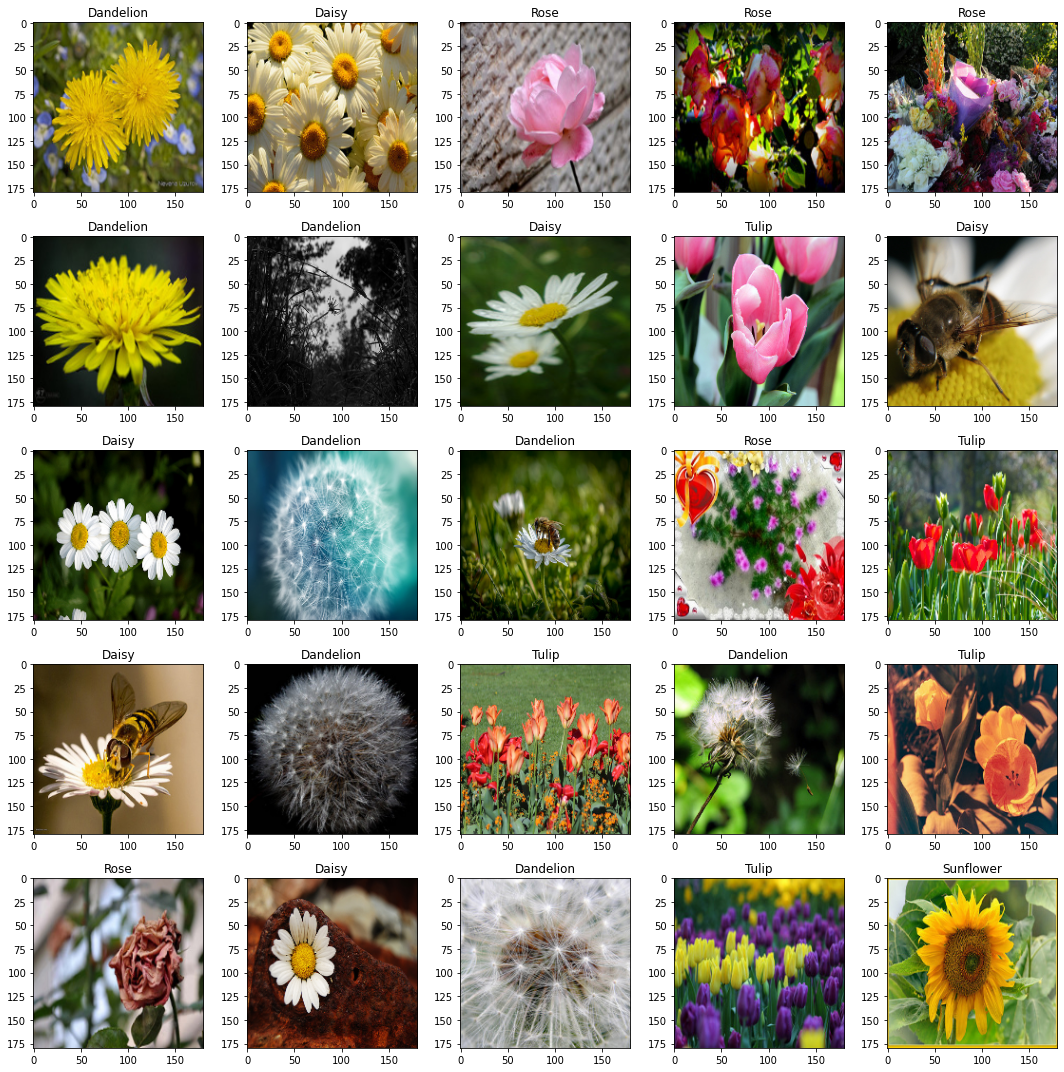

In [ ]:
fig,ax = plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (5):
        l = random.randint(0,len(flower_name))
        ax[i,j].imshow(flower_type[l])
        ax[i,j].set_title(flower_name[l])

plt.tight_layout()

#### Building the model

In [ ]:
le=LabelEncoder()
Y=le.fit_transform(flower_name)
Y=to_categorical(Y,5)
X=np.array(flower_type)
X=X/255

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

In [ ]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (180,180,3)))
model.add(MaxPooling2D(pool_size=(5,5)))

In [ ]:
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2,2)))

In [ ]:
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [ ]:
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [ ]:
datagen = ImageDataGenerator(featurewise_center=False,  samplewise_center=False,  featurewise_std_normalization=False,  samplewise_std_normalization=False,
                             zca_whitening=False,  rotation_range=10,  zoom_range = 0.1,  width_shift_range=0.2,  height_shift_range=0.2,  horizontal_flip=True,
                            vertical_flip=False)

In [ ]:
model.compile(optimizer=Adam(lr = 0.001),loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 96)        55392     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 96)        

In [ ]:
batch_size = 150
epochs = 25
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch = x_train.shape[0] // batch_size)

<ipython-input-39-2b1e049a8c3d>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/25
21/21 [==============================] - 137s 7s/step - loss: 1.4391 - accuracy: 0.3596 - val_loss: 1.7347 - val_accuracy: 0.3004
Epoch 2/25
21/21 [==============================] - 135s 6s/step - loss: 1.2253 - accuracy: 0.4556 - val_loss: 1.1236 - val_accuracy: 0.5296
Epoch 3/25
21/21 [==============================] - 134s 6s/step - loss: 1.0869 - accuracy: 0.5386 - val_loss: 1.1663 - val_accuracy: 0.5240
Epoch 4/25
21/21 [==============================] - 135s 6s/step - loss: 1.0481 - accuracy: 0.5703 - val_loss: 1.0013 - val_accuracy: 0.5832
Epoch 5/25
21/21 [==============================] - 135s 6s/step - loss: 0.9296 - accuracy: 0.6273 - val_loss: 0.8851 - val_accuracy: 0.6617
Epoch 6/25
21/21 [==============================] - 135s 6s/step - loss: 0.9074 - accuracy: 0.6284 - val_loss: 0.8873 - val_accuracy: 0.6442
Epoch 7/25
21/21 [==============================] - 136s 6s/step - loss: 0.8387 - accuracy: 0.6582 - val_loss: 0.9518 - val_accuracy: 0.6377
Epoch 8/25
21

#### Data Visualization

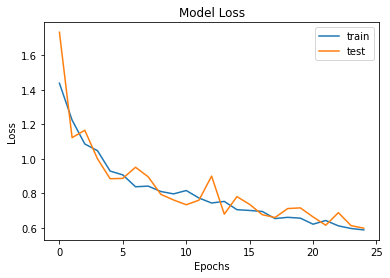

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

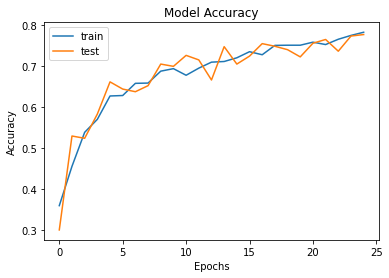

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### Checking The Accuracy of Image Prediction

In [ ]:
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

34/34 [==============================] - 11s 330ms/step


In [ ]:
# Take 25 photos for sample
classified=[]
for i in range(0, len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
      classified.append(i)
    if(len(classified)==25):
        break

missclassified=[]
for i in range(0, len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        missclassified.append(i)
    if(len(missclassified)==25):
        break

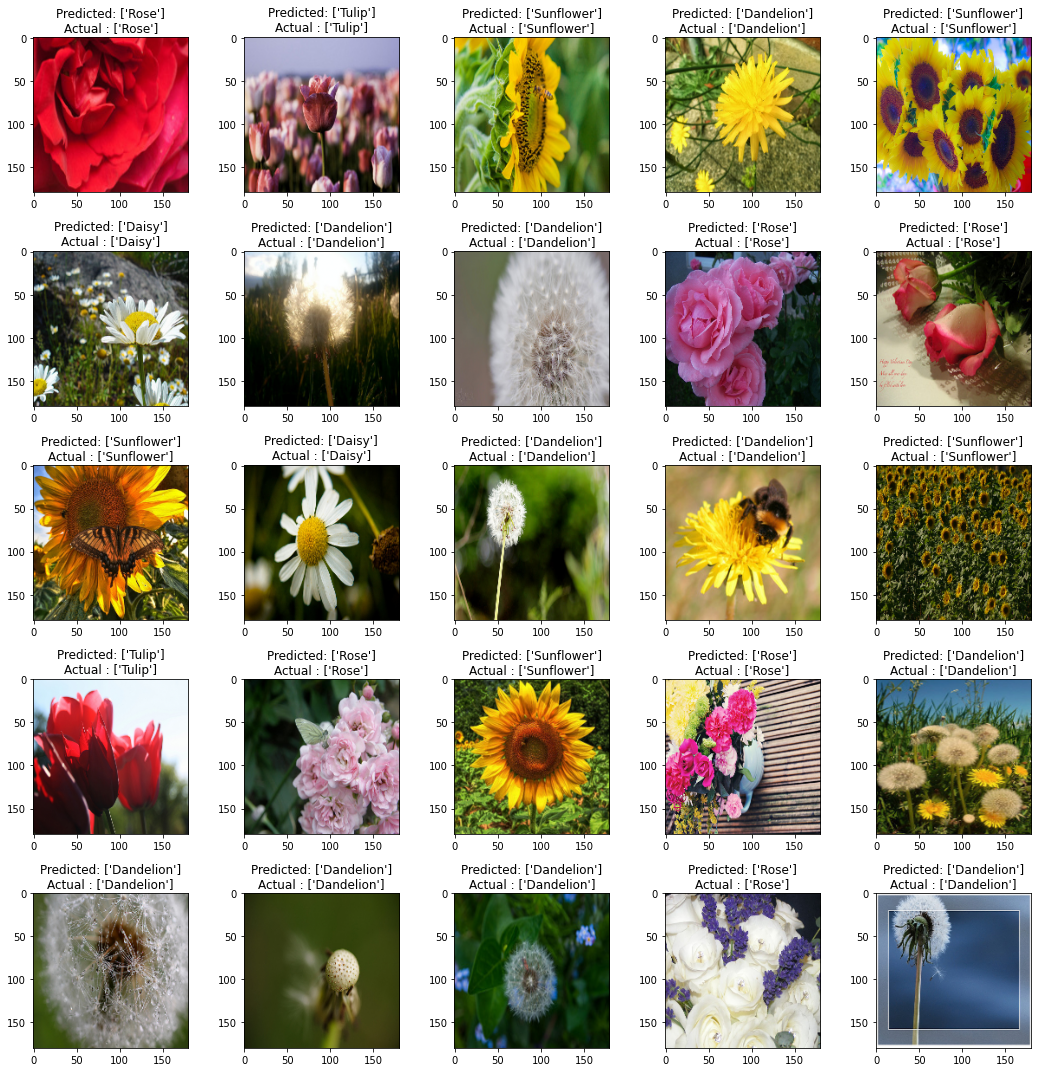

In [ ]:
count=0
fig,ax=plt.subplots(5, 5)
fig.set_size_inches(15,15)
for i in range (5):
    for j in range (5):
        ax[i,j].imshow(x_test[classified[count]])
        ax[i,j].set_title("Predicted: "+str(le.inverse_transform([pred_digits[classified[count]]]))+"\n"+"Actual : "+str(le.inverse_transform([np.argmax(y_test[classified[count]])])))
        plt.tight_layout()
        count+=1

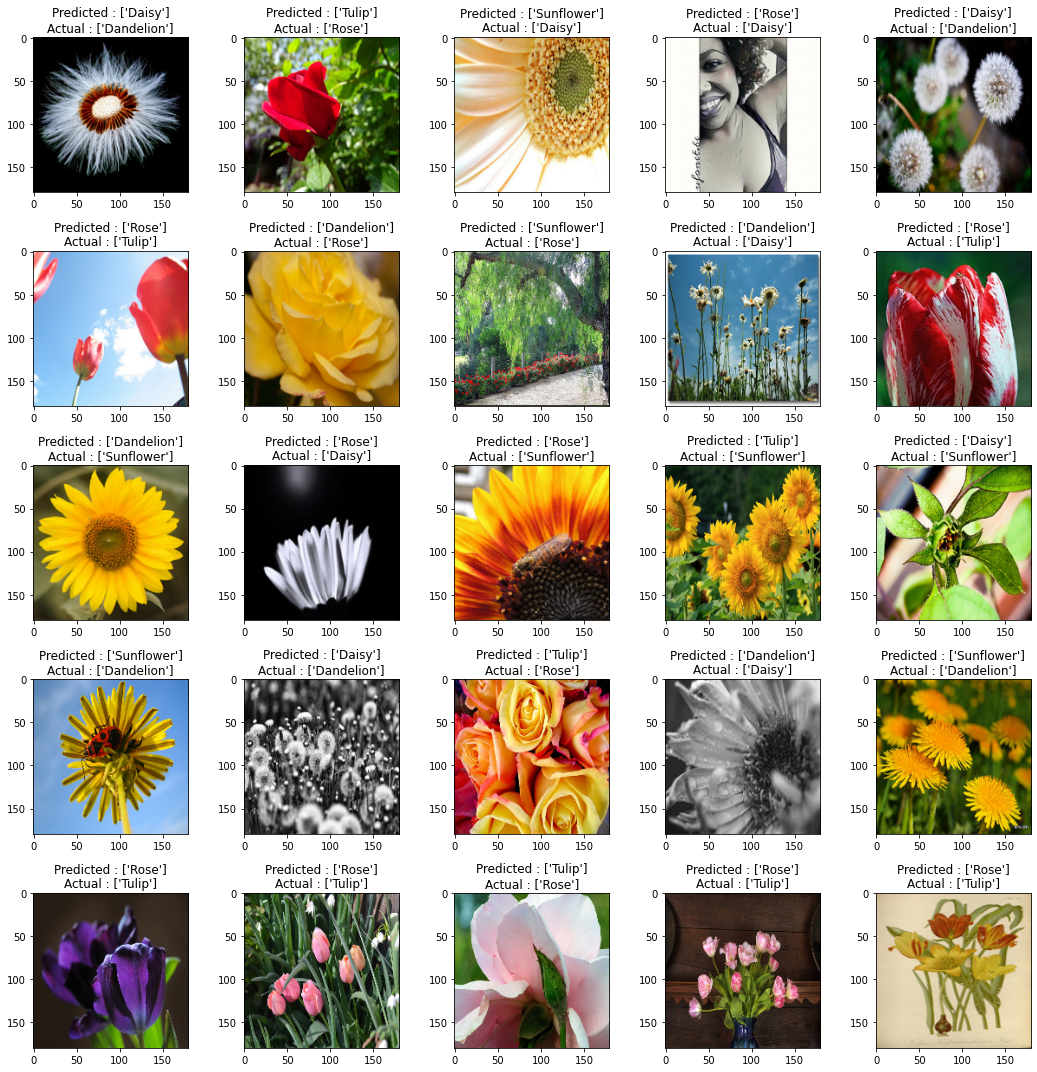

In [ ]:
count=0
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range (5):
    for j in range (5):
        ax[i,j].imshow(x_test[missclassified[count]])
        ax[i,j].set_title("Predicted : "+str(le.inverse_transform([pred_digits[missclassified[count]]]))+"\n"+"Actual : "+str(le.inverse_transform([np.argmax(y_test[missclassified[count]])])))
        plt.tight_layout()
        count+=1

In [ ]:
import pickle as pkl
filename = 'flower_classification.pkl'
pkl.dump(model, open(filename, 'wb'))

In [ ]:
cvscores = []
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

accuracy: 77.73%
77.73% (+/- 0.00%)
